<img src='./img/egu_2020.png' alt='Logo EU Copernicus EUMETSAT' align='left' width='30%'></img><img src='./img/atmos_logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='60%'></img></span>

<br>

<a href="./31_case_study_covid19_GOME2_anomaly_map.ipynb"><< 31 - Covid-19 - GOME-2 Anomaly Map </a><span style="float:right;"><a href="./33_case_study_covid-19_sentinel5p_maps.ipynb"> 33 - Covid-19 case study - Sentinel-5P Anomaly Map >></a></span>

### Covid-19 case study

# GOME-2 Tropospheric NO<sub>2</sub> longterm time-series


### Data used
The following data are used
- [GOME-2 Metop-A/B OFFLINE data](#offline)
- [GOME-2 NO2 Level 3 data from Feb 2007 to Nov 2017](#level3)


### Workflow outline
This workflow has the following outline:

- [Define a list with dictionaries holding bounding boxes for different regions](#region_list)
- [Load GOME-2 Level 3 data from February 2007 to November 2017](#level3)
- [Create (longterm) spatial means of tropospheric NO<sub>2</sub>](#longterm_mean)
- [Visualize (longterm) tropospheric NO<sub>2</sub>](#visualize)
 - [Plot tropospheric NO<sub>2</sub> time-series (2007 to 2017) for Europe, Po Valley (Italy) and Hubei region (China)](#plot_level3_ts)
 - [Plot longterm tropospheric NO<sub>2</sub> climatology for Europe, Po Valley (Italy) and Hubei region (China)](#plot_climatology)
- [Load gridded Level 3 data of tropospheric NO<sub>2</sub> for January and April 2020](#load_gridded_nc)
 - [Generate geographical mean for regions for Jan and April 2020](#generate_geographical_mean)
 - [Retrieve time-series values for January and April between 2007 and 2017](#retrieve_ts_values)
 - [Re-organize the time-series information into a pandas.DataFrame](#reorganise)
- [Visualize time-series of tropospheric NO<sub>2</sub> values in January and April as bar plot](#visualize_bar_plot)
 

#### Load required libraries

In [1]:
import os
import xarray as xr
import numpy as np
import netCDF4 as nc

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import cartopy.feature as cfeature

import glob
import pandas as pd

from datetime import datetime

import ipynb
import geopandas as gpd

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

#### Load helper functions

In [2]:
from ipynb.fs.full.functions import load_l2_data_xr, visualize_pcolormesh, generate_masked_array, generate_geographical_subset


<hr>

## <a id='region_list'></a>Define a list with dictionaries holding bounding boxes for different regions

You can define several regions as a dictionary, e.g. the bounding box information for Europe, the Po valley in Italy or the Hubei region in China. The dictionaries are stored in a list.

In [3]:
# Europe extent
eur_extent={'name': 'eur_extent',
    'lonmin':-10.0,
            'lonmax':30.0,
            'latmin':35.0,
            'latmax':60.0}

# Italy (Po Valley, Milano)
povalley_extent={'name': 'povalley_extent',
    'lonmin':7.0,
            'lonmax':13.0,
            'latmin':44.0,
            'latmax':47.0}

# China (Hubei, Wuhan)
hubei_extent={'name': 'hubei_extent',
    'lonmin':112.0,
            'lonmax':118.0,
            'latmin':28.0,
            'latmax':33.0}

region_list=[eur_extent,
             povalley_extent,
            hubei_extent]

## <a id='level3'></a>Load GOME-2 Level 3 data from February 2007 to November 2017

Global GOME-2 Level 3 data are available from February 2007 to November 2017. From this longterm time-series, you can create a spatial average of a specific region and visualize the monthly tropospheric NO<sub>2</sub> content over time.

#### Load the GOME-2 Level 3 data files as `xarray.DataArray` with the function `xarray.open_mfdataset()`

The GOME-2 Level 3 data are disseminated in `netCDF`. The function `xarray.open_mfdataset()` can be used to load the data for all month at once. Use `time` for the keyword argument `concat_dim`.

In [4]:
gome_l3 = xr.open_mfdataset('./eodata/gome2/level3/no2/*.nc', concat_dim='time', combine='nested',  group='PRODUCT')
gome_l3

<xarray.Dataset>
Dimensions:          (latitude: 720, longitude: 1440, time: 130)
Dimensions without coordinates: latitude, longitude, time
Data variables:
    NO2total         (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_err     (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_stddev  (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop          (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_err      (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_stddev   (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs             (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

Above, you can see that the `xarray.Dataset` has three dimensions (`latitude`, `longitude` and `time`), but the dimensions do not have coordinates. But the coordinate information is required for plotting.

As a next step, we load one single GOME-2 Level 3 file and retrieve the `latitude` and `longitude` coordinates. You can use this information to assign the coordinates to the Dataset above.

In [5]:
ds = xr.open_dataset('./eodata/gome2/level3/no2/GOME_NO2_Global_201701_METOPB_DLR_v1.nc')
ds, ds.latitude, ds.longitude

(<xarray.Dataset>
 Dimensions:    (latitude: 720, longitude: 1440)
 Coordinates:
   * latitude   (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
   * longitude  (longitude) float32 -179.875 -179.625 ... 179.625 179.875
 Data variables:
     *empty*
 Attributes:
     description:  Level 3 NO2 data
     Conventions:  CF-1.6, <xarray.DataArray 'latitude' (latitude: 720)>
 array([-89.875, -89.625, -89.375, ...,  89.375,  89.625,  89.875],
       dtype=float32)
 Coordinates:
   * latitude  (latitude) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
 Attributes:
     standard_name:  latitude
     long_name:      latitude_Centre, center of the grid box
     units:          degrees_north, <xarray.DataArray 'longitude' (longitude: 1440)>
 array([-179.875, -179.625, -179.375, ...,  179.375,  179.625,  179.875],
       dtype=float32)
 Coordinates:
   * longitude  (longitude) float32 -179.875 -179.625 ... 179.625 179.875
 Attributes:
     standard_name:  longitude
     long_name:    

#### Assign coordinates to the dimensions `latitude`, `longitude` and `time`

You can use `pandas.data_range` to build a list of monthly time coordinates from February 2007 to November 2017.

In [6]:
# Build list of time coordinates with pandas
time_coords = pd.date_range('2007-02', '2017-11', freq='MS').strftime("%Y-%m").astype('datetime64[ns]')
time_coords

DatetimeIndex(['2007-02-01', '2007-03-01', '2007-04-01', '2007-05-01',
               '2007-06-01', '2007-07-01', '2007-08-01', '2007-09-01',
               '2007-10-01', '2007-11-01',
               ...
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01'],
              dtype='datetime64[ns]', length=130, freq=None)

Use the function `xarray.assign_coords()` to assign `latitude`, `longitude` and `time` coordinates to the gome_l3 dataset.

In [7]:
# Assign values to Dataset dimension
gome_l3_assigned = gome_l3.assign_coords(latitude=ds.latitude, longitude=ds.longitude, time=time_coords)
gome_l3_assigned

<xarray.Dataset>
Dimensions:          (latitude: 720, longitude: 1440, time: 130)
Coordinates:
  * latitude         (latitude) float32 -89.875 -89.625 ... 89.625 89.875
  * longitude        (longitude) float32 -179.875 -179.625 ... 179.625 179.875
  * time             (time) datetime64[ns] 2007-02-01 2007-03-01 ... 2017-11-01
Data variables:
    NO2total         (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_err     (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2total_stddev  (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop          (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_err      (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    NO2trop_stddev   (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    nobs             (time, latitude, longitude) float32 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

## <a id='longterm_mean'></a> Create (longterm) spatial means of tropospheric NO<sub>2</sub>

Let us loop through the list of regions and create a dictionary containing two lists:
- **no2_l3**: the spatial average for each month of tropospheric NO<sub>2</sub> of the specific region, and
- **no2_monthly_avg**: the longterm mean of tropospheric NO<sub>2</sub> of each month

The loop makes use of the function [generate_geographical_subset](./functions.ipynb#geographical_subset), which creates a smaller spatial subset based on the bounding box information of each region.

The spatial average of a `xarray.DataArray` is computed with the function `xarray.DataArray.mean()` and specifying the dimension to apply the spatial average with `dim=['latitude', 'longitude']`.

The longterm average is retrieved by using xarray's `groupby('time.month').mean()` aggregator.

In [8]:
# Retrieve the tropospheric NO2 from the xarray Dataset
no2_l3 = gome_l3_assigned.NO2trop

# Initialise an empty dictionary
gome2_l3_dict = {}

# Loop through each item in region list
for region in region_list:
    print(region)
    # Generate a geographical subset
    tmp = generate_geographical_subset(no2_l3,
                                          region['latmin'],
                                          region['latmax'],
                                          region['lonmin'],
                                          region['lonmax'])
    # Create the spatial average of the region
    tmp_mean = tmp.mean(dim=['latitude','longitude'])
    # Create the longterm climatology of each month
    tmp_climatology_mean = tmp_mean.groupby('time.month').mean()
    # Fill the dictionary with the two lists
    gome2_l3_dict[region['name']]={'no2_l3':tmp_mean,
                                  'no2_monthly_avg': tmp_climatology_mean}


{'name': 'eur_extent', 'lonmin': -10.0, 'lonmax': 30.0, 'latmin': 35.0, 'latmax': 60.0}
{'name': 'povalley_extent', 'lonmin': 7.0, 'lonmax': 13.0, 'latmin': 44.0, 'latmax': 47.0}
{'name': 'hubei_extent', 'lonmin': 112.0, 'lonmax': 118.0, 'latmin': 28.0, 'latmax': 33.0}


The resulting dictionary contains the three regions as keys and for each region, you can retrieve the time series and climatology of tropospheric NO<sub>2</sub>.

In [9]:
gome2_l3_dict['eur_extent']['no2_l3']

<xarray.DataArray 'NO2trop' (time: 130)>
dask.array<mean_agg-aggregate, shape=(130,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2007-02-01 2007-03-01 ... 2017-11-01

## <a id='visualize'></a>Visualize (longterm) tropospheric NO<sub>2</sub> 

### <a id='plot_level3_ts'></a>Plot tropospheric NO<sub>2</sub> time-series (2007 to 2017) for Europe, Po Valley (Italy) and Hubei region (China)

Let us visualize the tropospheric NO<sub>2</sub> time-series from 2007 to 2017. You can make use of the `xarray.DataArray.plot.line()` function. As dictionary key, you select for each region the `no2_l3` time-series.

You can define a conversion factor to make the visualisation of the NO<sub>2</sub> more readable. 

In [10]:
conversion_factor = 1e-15

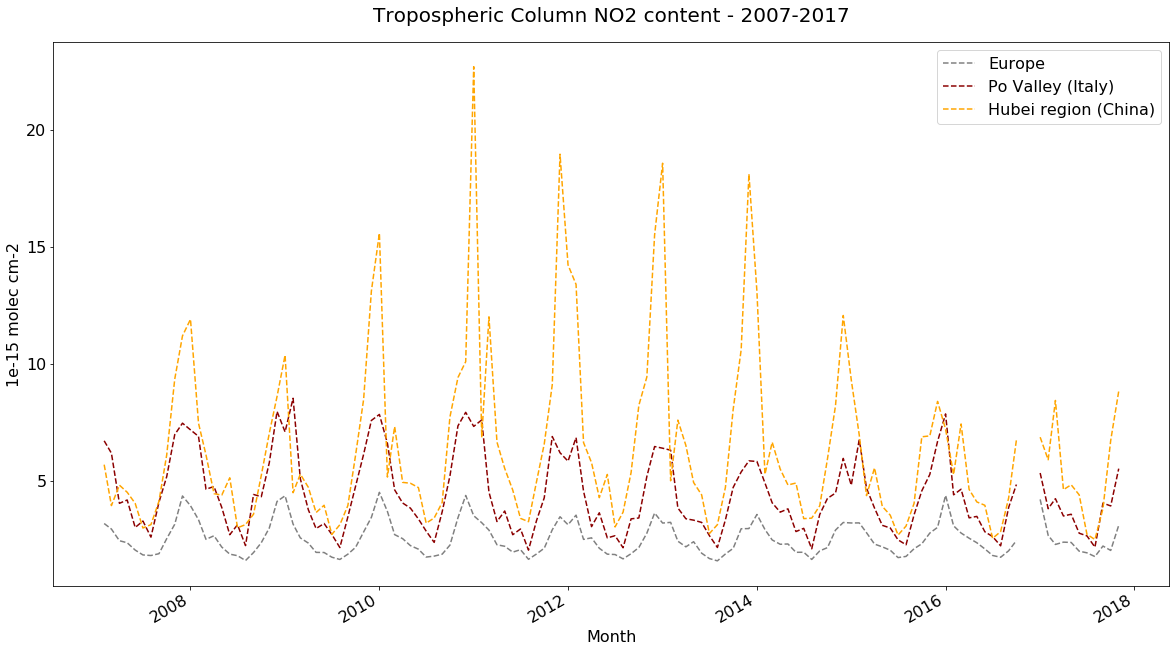

In [11]:
fig = plt.figure(figsize=(20,10))

(gome2_l3_dict['eur_extent']['no2_l3']*conversion_factor).plot.line(
    linestyle='dashed',
    color='grey', 
    label='Europe')

(gome2_l3_dict['povalley_extent']['no2_l3']*conversion_factor).plot.line(
    linestyle='dashed',
    color='darkred', 
    label='Po Valley (Italy)')

(gome2_l3_dict['hubei_extent']['no2_l3']*conversion_factor).plot.line(
    linestyle='dashed',
    color='orange',
    label='Hubei region (China)')


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title(no2_l3.long_name + " - 2007-2017", fontsize=20, pad=20)
plt.ylabel(str(conversion_factor) + ' ' + no2_l3.units, fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.legend(fontsize=16,loc=0)
plt.show()

### <a id='plot_climatology'></a> Plot longterm tropospheric NO<sub>2</sub> climatology for Europe, Po Valley (Italy) and Hubei region (China)

Let us visualize the longterm tropospheric NO<sub>2</sub> climatology for each month (based on the 2007 to 2017 time-series). You can make use of the `xarray.DataArray.plot.line()` function. As dictionary key, you select for each region the `no2_monthly_avg` time-series.

You apply again the conversion factor to make the visualisation of the NO<sub>2</sub> more readable. 

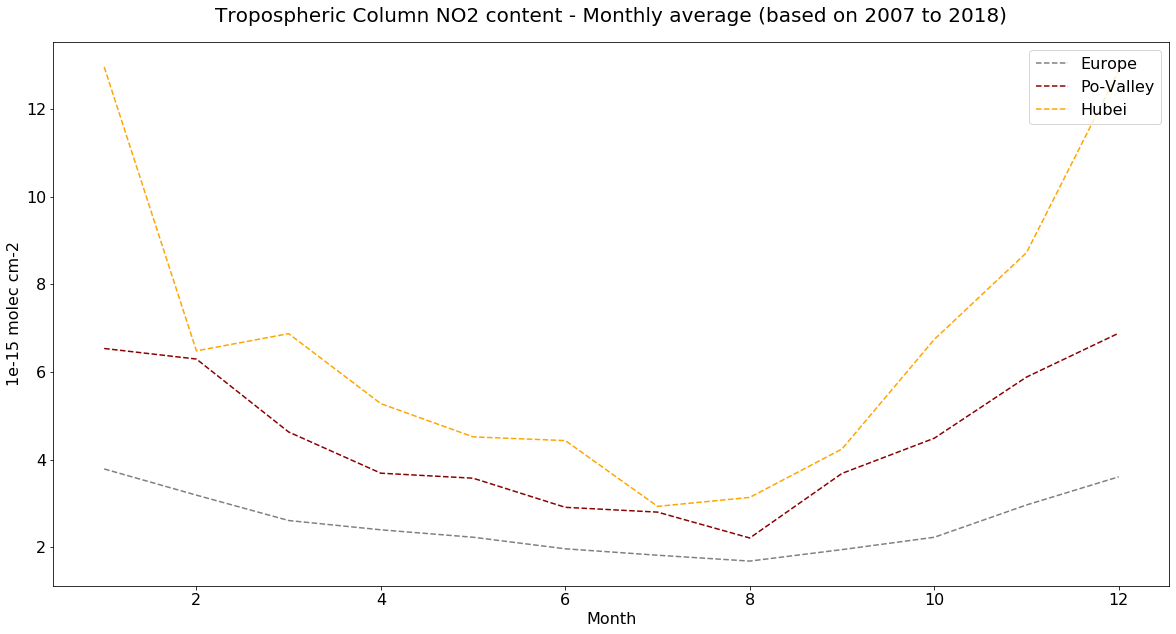

In [12]:
fig = plt.figure(figsize=(20,10))

(gome2_l3_dict['eur_extent']['no2_monthly_avg']*conversion_factor).plot.line(
    linestyle='dashed',
    color='grey', 
    label='Europe')

(gome2_l3_dict['povalley_extent']['no2_monthly_avg']*conversion_factor).plot.line(
    linestyle='dashed',
    color='darkred', 
    label='Po-Valley')

(gome2_l3_dict['hubei_extent']['no2_monthly_avg']*conversion_factor).plot.line(
    linestyle='dashed',
    color='orange', 
    label='Hubei')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Tropospheric Column NO2 content - Monthly average (based on 2007 to 2018)", fontsize=20, pad=20)
plt.ylabel(str(conversion_factor) + ' ' + no2_l3.units, fontsize=16)
plt.xlabel('Month', fontsize=16)
plt.legend(fontsize=16,loc=1)
plt.show()

## <a id='load_gridded_nc'></a>Load gridded Level 3 data of tropospheric NO<sub>2</sub> for January and March 2020

Load the re-gridded GOME-2 Level 3 data for January and March 2020 as `xarray.DataArray`. You can use the function `open_dataset`.

In [13]:
data_array_2001 = xr.open_dataset('./eodata/gome2/level3/no2/2020/2001_gome2_l3.nc')
data_array_2004 = xr.open_dataset('./eodata/gome2/level3/no2/2020/2004_gome2_l3.nc')

### <a id='geographical_mean'></a>Generate geographical mean for regions for Jan and March 2020

In [14]:
gome2_l3_2020_dict = {}
for region in region_list:
    print(region['name'])
    tmp_01 = generate_geographical_subset(data_array_2001,
                                          region['latmin'],
                                          region['latmax'],
                                          region['lonmin'],
                                          region['lonmax'])
    tmp_04 = generate_geographical_subset(data_array_2004,
                                          region['latmin'],
                                          region['latmax'],
                                          region['lonmin'],
                                          region['lonmax'])
    tmp_mean_01 = tmp_01.mean(dim=['latitude','longitude'])
    tmp_mean_04 = tmp_04.mean(dim=['latitude','longitude'])
    print(tmp_mean_01,tmp_mean_04)
    gome2_l3_2020_dict[region['name']]={'no2_2001_mean':tmp_mean_01.NO2_tropo.values.item(),
                                       'no2_2004_mean': tmp_mean_04.NO2_tropo.values.item()}    



eur_extent
<xarray.Dataset>
Dimensions:    ()
Coordinates:
    time       datetime64[ns] 2020-01-01
Data variables:
    NO2_tropo  float64 2.719e+15 <xarray.Dataset>
Dimensions:    ()
Coordinates:
    time       datetime64[ns] 2020-04-01
Data variables:
    NO2_tropo  float64 2.029e+15
povalley_extent
<xarray.Dataset>
Dimensions:    ()
Coordinates:
    time       datetime64[ns] 2020-01-01
Data variables:
    NO2_tropo  float64 6.135e+15 <xarray.Dataset>
Dimensions:    ()
Coordinates:
    time       datetime64[ns] 2020-04-01
Data variables:
    NO2_tropo  float64 2.595e+15
hubei_extent
<xarray.Dataset>
Dimensions:    ()
Coordinates:
    time       datetime64[ns] 2020-01-01
Data variables:
    NO2_tropo  float64 3.342e+15 <xarray.Dataset>
Dimensions:    ()
Coordinates:
    time       datetime64[ns] 2020-04-01
Data variables:
    NO2_tropo  float64 5.74e+15


### <a id='retrieve_ts_values'></a> Retrieve time-series values for January and April between 2007 and 2017

We loop again over each region and retrieve from the dictionary key `gome2_l3_dict['region']['no2_l3']` the tropospheric NO<sub>2</sub> for January and April. We additionally add to the GOME-2 Level 3 time-series the average values for this year year January and March.

In [15]:
dict_mean_jan_apr = {}

for region in region_list:
    print(region)
    name = region['name']
    tmp_no2 = gome2_l3_dict[name]['no2_l3']

    
    tmp_no2_jan = tmp_no2[11::12].to_pandas()
    tmp_no2_apr = tmp_no2[2::12].to_pandas()
    
    tmp_no2_jan.loc[pd.to_datetime('2019-01-01')]=np.nan
    tmp_no2_apr.loc[pd.to_datetime('2019-04-01')]=np.nan

    tmp_no2_jan.loc[pd.to_datetime('2018-01-01')]=np.nan
    tmp_no2_apr.loc[pd.to_datetime('2018-04-01')]=np.nan

    tmp_no2_jan.loc[pd.to_datetime('2020-01-01')]=gome2_l3_2020_dict[name]['no2_2001_mean']
    tmp_no2_apr.loc[pd.to_datetime('2020-04-01')]=gome2_l3_2020_dict[name]['no2_2004_mean']
    
    dict_mean_jan_apr[region['name']]={'ts_no2_jan':tmp_no2_jan,
                                      'ts_no2_apr':tmp_no2_apr}



{'name': 'eur_extent', 'lonmin': -10.0, 'lonmax': 30.0, 'latmin': 35.0, 'latmax': 60.0}
{'name': 'povalley_extent', 'lonmin': 7.0, 'lonmax': 13.0, 'latmin': 44.0, 'latmax': 47.0}
{'name': 'hubei_extent', 'lonmin': 112.0, 'lonmax': 118.0, 'latmin': 28.0, 'latmax': 33.0}


The dictionary holds two time-series for January and April tropospheric NO<sub>2</sub> from 2007 to 2017 and 2020.

In [16]:
dict_mean_jan_apr['eur_extent']

{'ts_no2_jan': time
 2008-01-01    3.922452e+15
 2009-01-01    4.347155e+15
 2010-01-01    4.494229e+15
 2011-01-01    3.493711e+15
 2012-01-01    3.110268e+15
 2013-01-01    3.181364e+15
 2014-01-01    3.549844e+15
 2015-01-01    3.184725e+15
 2016-01-01    4.364594e+15
 2017-01-01    4.191760e+15
 2019-01-01             NaN
 2018-01-01             NaN
 2020-01-01    2.719130e+15
 dtype: float64, 'ts_no2_apr': time
 2007-04-01    2.426408e+15
 2008-04-01    2.638714e+15
 2009-04-01    2.325386e+15
 2010-04-01    2.514584e+15
 2011-04-01    2.253388e+15
 2012-04-01    2.549694e+15
 2013-04-01    2.165288e+15
 2014-04-01    2.275193e+15
 2015-04-01    2.282426e+15
 2016-04-01    2.534856e+15
 2017-04-01    2.365718e+15
 2019-04-01             NaN
 2018-04-01             NaN
 2020-04-01    2.029405e+15
 dtype: float64}

### <a id='reorganise'></a>Re-organize the time-series information into a `pandas.DataFrame`

For plotting, it is easier to re-organize the time series stored in the dictionary into a `pandas.DataFrame`. In order to combine both time series with the same `time` index, you have to equalize the index to only store the year.
The re-organisation into a `pandas.DataFrame` is a three-step process:
- 1. Retrieve each time series in the dictionary and convert it to a `pandas.DataFrame` with the function `to_frame()`
- 2. Equalize the index of both data frames, by reducing the time to `Year` only. You can do this with `index.strftime('%Y')`
- 3. Add the April dataframe as additionaly column to the data frame with the January time-series values

In [17]:
region = 'hubei_extent'
# 1. Retrieve each time-series and covert it to a panda DataFrame
no2_mean_jan_df = dict_mean_jan_apr[region]['ts_no2_jan'].to_frame('Jan')
no2_mean_apr_df = dict_mean_jan_apr[region]['ts_no2_apr'].to_frame('Apr')

# 2. Equalize the index of both DataFrames
no2_mean_jan_df.index = no2_mean_jan_df.index.strftime('%Y')
no2_mean_apr_df.index = no2_mean_apr_df.index.strftime('%Y')

# 3. Bring both data frames together into one
no2_mean_jan_df['Apr']=no2_mean_apr_df

# sort index
eur_df = no2_mean_jan_df.sort_index()
eur_df

,Jan,Apr
2008,1.189021e+16,4.438904e+15
2009,1.035613e+16,4.710326e+15
2010,1.557088e+16,4.920221e+15
2011,2.268715e+16,6.641834e+15
2012,1.421342e+16,5.760870e+15
2013,1.856009e+16,6.498384e+15
2014,1.306744e+16,5.489462e+15
2015,9.303024e+15,5.539780e+15
2016,7.193228e+15,4.618634e+15
2017,6.851193e+15,4.608598e+15


## <a id='visualize_bar_plot'></a>Visualize time-series of tropospheric NO<sub>2</sub> values in January and March as bar plot

Visualize the `pandas.DataFrame` as bar plot with the function `plot.bar()`.

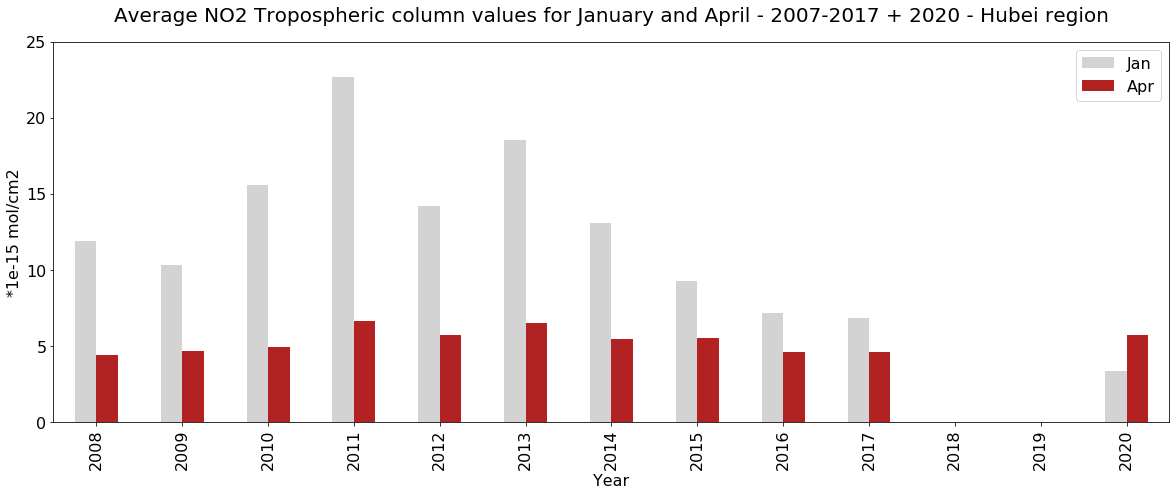

In [18]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(20,7))

(eur_df*conversion_factor).plot.bar( 
    ax=ax, 
    color=['lightgrey','firebrick'])

plt.ylim(0,25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Average NO2 Tropospheric column values for January and April - 2007-2017 + 2020 - Hubei region', fontsize=20, pad=20)
plt.ylabel('*'+str(conversion_factor) + ' ' + 'mol/cm2', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.legend(fontsize=16,loc=1)
plt.show()

<br>

<a href="./31_case_study_covid19_GOME2_anomaly_map.ipynb"><< 31 - Covid-19 - GOME-2 Anomaly Map </a><span style="float:right;"><a href="./33_case_study_covid-19_sentinel5p_maps.ipynb"> 33 - Covid-19 case study - Sentinel-5P Anomaly Map >></a></span>

<hr>

<img src='./img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.